### BREAST CANCER CLASSIFICATION

#### 1. iMPORT lIBRARIES

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#### 2. DATA PREPROCESSING, EDA

In [2]:
# Directories
train_dir = r"C:\Users\srira\Downloads\SEMESTER 2\Mini Project\Breast Cancer Dataset\train"
val_dir = r"C:\Users\srira\Downloads\SEMESTER 2\Mini Project\Breast Cancer Dataset\valid"
test_dir = r"C:\Users\srira\Downloads\SEMESTER 2\Mini Project\Breast Cancer Dataset\test"

In [3]:
# Image Size and Parameters
img_size = (224, 224)
batch_size = 32

In [4]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, rotation_range=15)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, class_mode='categorical', batch_size=batch_size)
val_data = val_datagen.flow_from_directory(val_dir, target_size=img_size, class_mode='categorical', batch_size=batch_size)
test_data = test_datagen.flow_from_directory(test_dir, target_size=img_size, class_mode='categorical', 
                                             batch_size=batch_size, shuffle=False)

Found 1105 images belonging to 3 classes.
Found 148 images belonging to 3 classes.
Found 325 images belonging to 3 classes.


C:\Users\srira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


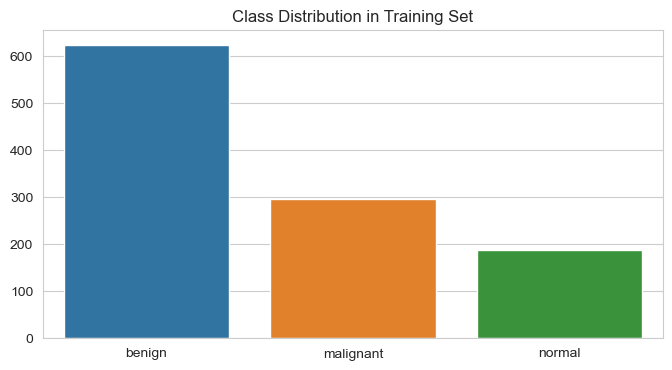

In [5]:
# EDA - Class Distribution
sns.set_style("whitegrid")
labels = list(train_data.class_indices.keys())
counts = [len(os.listdir(os.path.join(train_dir, label))) for label in labels]
plt.figure(figsize=(8, 4))
sns.barplot(x=labels, y=counts)
plt.title("Class Distribution in Training Set")
plt.show()

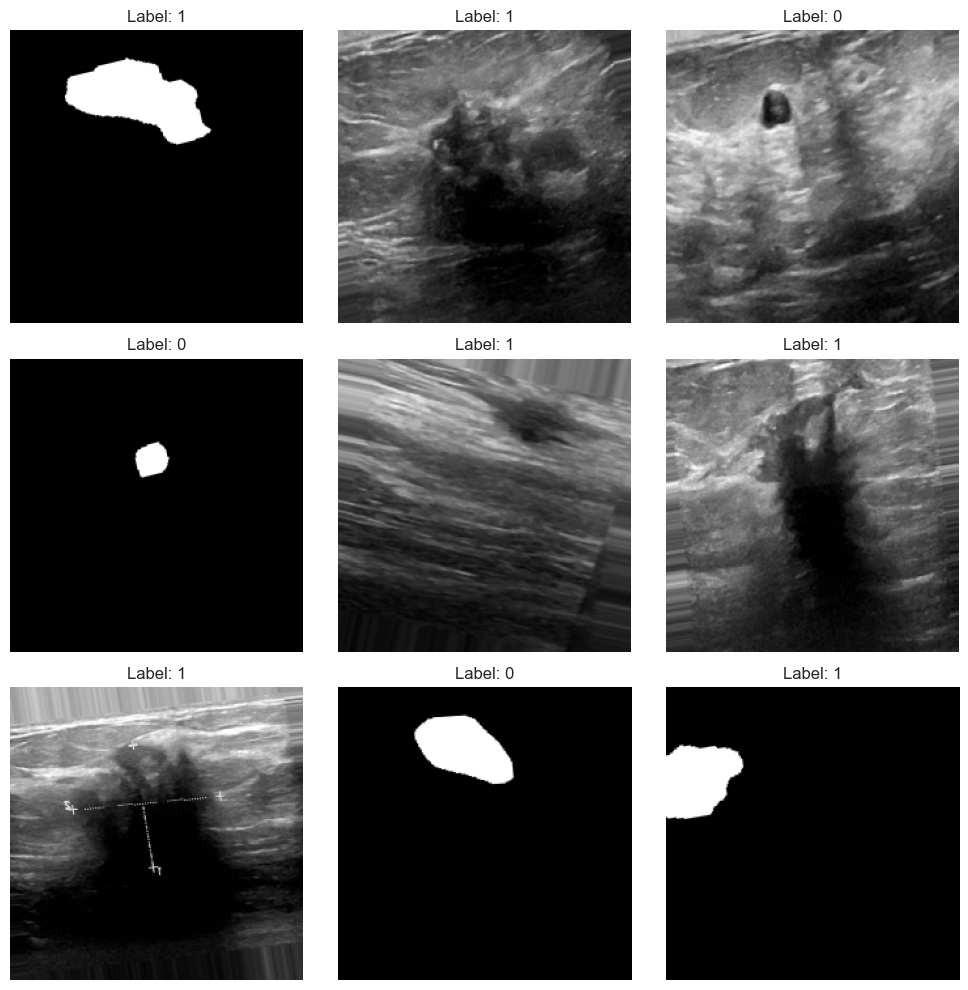

In [7]:
# Show Sample Images
x, y = next(train_data)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x[i])
    plt.title(f"Label: {np.argmax(y[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#### 3. MODEL BUILDING

In [9]:
from tensorflow.keras.layers import Concatenate

def hardblock(input_tensor, filters, depth=3):
    layers = [input_tensor]
    for i in range(depth):
        out = Conv2D(filters, (3,3), padding='same')(layers[-1])
        out = BatchNormalization()(out)
        out = ReLU()(out)
        layers.append(out)
    return Concatenate()(layers[1:])  # Skip the original input to match filter depth growth

In [10]:
def build_hardnet_39(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # HarDBlocks (Simplified)
    x = hardblock(x, 32)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = hardblock(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = hardblock(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = hardblock(x, 160)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
# Instantiate Model
model = build_hardnet_39(num_classes=train_data.num_classes)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_17 (Conv2D)            │ (None, 112, 112, 32)      │             896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_17        │ (None, 112, 112, 32)      │             128 │ conv2d_17[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_17 (ReLU)               │ (None, 112, 112, 32)      │               0 │ batch_normalization_17[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_18 (Conv2D)            │ (None, 112, 112, 32)      │           9,248 │ re_lu_17[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 112, 112, 32)      │             128 │ conv2d_18[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_18 (ReLU)               │ (None, 112, 112, 32)      │               0 │ batch_normalization_18[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 112, 112, 32)      │           9,248 │ re_lu_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_19        │ (None, 112, 112, 32)      │             128 │ conv2d_19[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_19 (ReLU)               │ (None, 112, 112, 32)      │               0 │ batch_normalization_19[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 112, 112, 32)      │           9,248 │ re_lu_19[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_20        │ (None, 112, 112, 32)      │             128 │ conv2d_20[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_20 (ReLU)               │ (None, 112, 112, 32)      │               0 │ batch_normalization_20[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 112, 112, 96)      │               0 │ re_lu_18[0][0],            │
│                               │                           │                 │ re_lu_19[0][0],            │
│                               │                           │                 │ re_lu_20[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,817,219 (6.93 MB)

 Trainable params: 1,814,851 (6.92 MB)

 Non-trainable params: 2,368 (9.25 KB)

#### 4. MODEL TRAINING

In [15]:
history = model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.5403 - loss: 0.9749 - val_accuracy: 0.2838 - val_loss: 1.1765
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.7465 - loss: 0.6149 - val_accuracy: 0.2838 - val_loss: 1.2130
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.7290 - loss: 0.6221 - val_accuracy: 0.2838 - val_loss: 1.1979
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7831 - loss: 0.5455 - val_accuracy: 0.2838 - val_loss: 1.1679
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - accuracy: 0.7705 - loss: 0.5363 - val_accuracy: 0.4459 - val_loss: 1.0791
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.8028 - loss: 0.5118 - val_accuracy: 0.4459 - val_loss: 1.2393
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.7805 - loss: 0.4933 - val_accuracy: 0.4459 - val_loss: 1.6084
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8257 - loss: 0.4456 - val_accuracy: 0.4459 - v

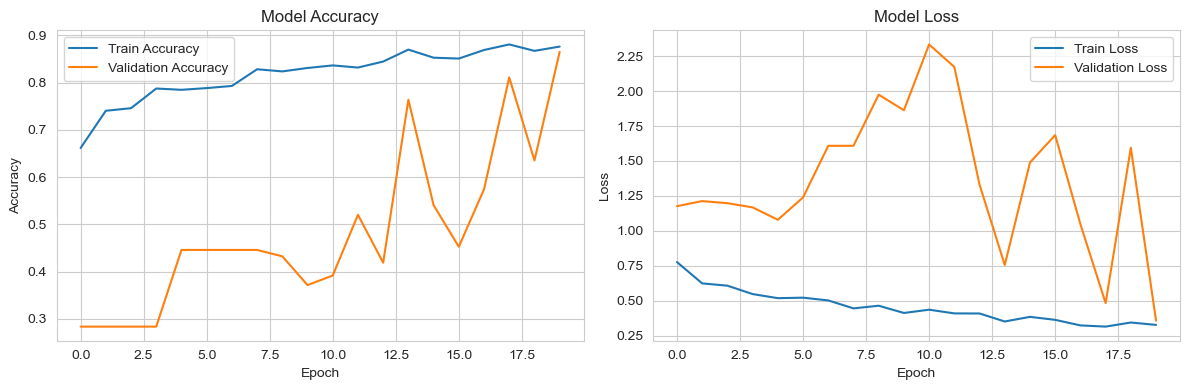

In [16]:
# Step 6: Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#### 5. MODEL EVALUATION

In [17]:
loss, acc = model.evaluate(test_data)
print(f"\nTest Accuracy: {acc*100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7833 - loss: 0.4635

Test Accuracy: 84.92%


In [18]:
# Classification Report
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step

Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.85      0.90       227
   malignant       0.63      0.83      0.72        60
      normal       0.76      0.89      0.82        38

    accuracy                           0.85       325
   macro avg       0.78      0.86      0.81       325
weighted avg       0.87      0.85      0.86       325



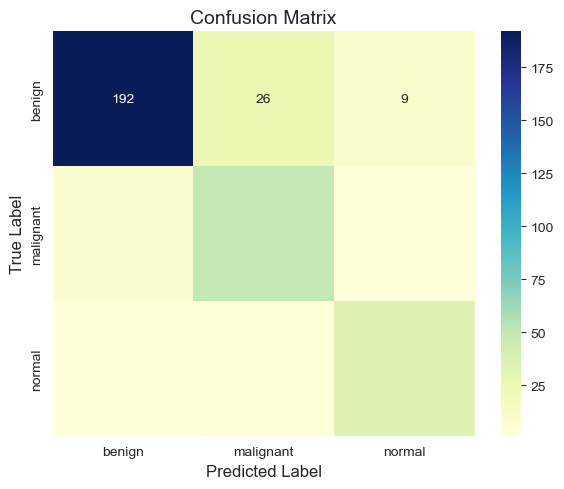

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 708ms/step
ROC AUC Score (macro-average): 0.9569


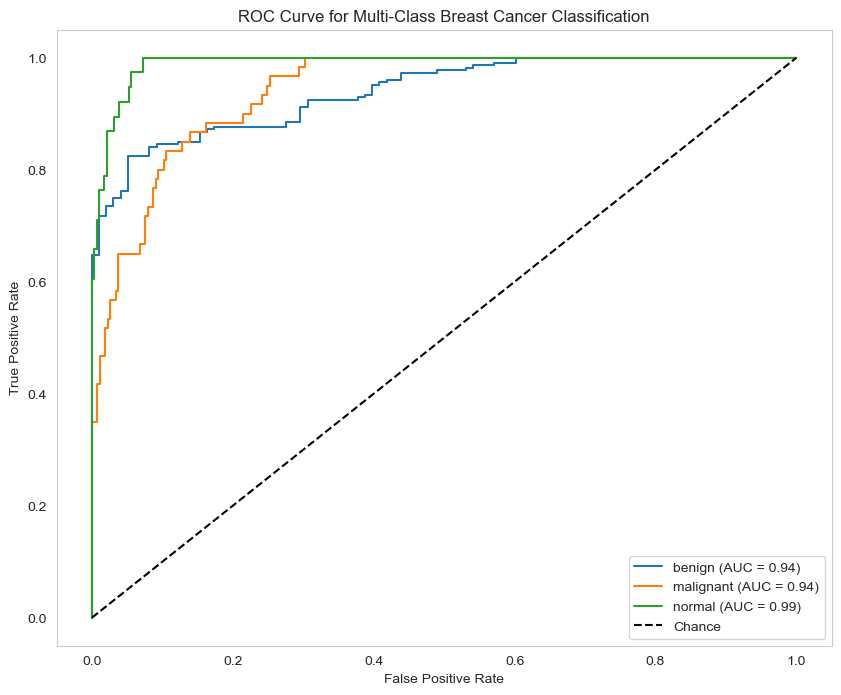

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get the number of classes and class labels
class_labels = list(test_data.class_indices.keys())
num_classes = len(class_labels)

# True labels
y_true = test_data.classes

# Binarize the output labels (needed for multi-class AUC)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Predicted probabilities
y_pred_prob = model.predict(test_data)

# Compute ROC AUC Score (macro-average for multi-class)
roc_auc = roc_auc_score(y_true_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f"ROC AUC Score (macro-average): {roc_auc:.4f}")

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc_i:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Breast Cancer Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()